In [1]:
import pandas as pd
from functions import calc, retrieve, visualize as viz

import warnings
warnings.filterwarnings('ignore')

%colors nocolor

In [2]:
def get_and_store_raw_data(fromCSV, numberOfStocks=50, daysSince=30):
    tickers_df = retrieve.get_tickers(numberOfStocks)
    if (fromCSV):
        print ("Returning stored data.")
        (rawdata, spreads, volumes) = ((pd.read_csv('data/close.csv')).set_index('Date'),
                            (pd.read_csv('data/spreads.csv')).set_index('Date'),
                            (pd.read_csv('data/volumes.csv')).set_index('Date'))
    else:
        downloadedData = retrieve.get_downloaded_data(tickers_df, numberOfStocks, daysSince)
        rawdata = downloadedData['Close']
        spreads = (downloadedData['High'] - downloadedData['Low'])/(downloadedData['Close'])
        volumes = downloadedData['Volume']
        rawdata.to_csv('./data/close.csv')
        spreads.to_csv('./data/spreads.csv')
        volumes.to_csv('./data/volumes.csv')

    return (rawdata, spreads, volumes, tickers_df)
    
def processData(closes, volumes, QUICK_EMA_PERIOD=7, SLOW_EMA_PERIOD=14, latestWindow=2):
    print ("Calculating indicators...")
    companies = closes.columns.values

    EMA_df = calc.get_EMA_df(QUICK_EMA_PERIOD, SLOW_EMA_PERIOD, closes)
    OBV_df= calc.get_OBV_df(volumes, closes)
    keyStats = calc.get_intersection_point(EMA_df, closes)
    (keyStats['avgRatio'], keyStats['MinAbsRatio']) = calc.ratioWrapper(EMA_df, companies, keyStats)
    keyStats['latestGrowth'] = round(closes.pct_change()[-latestWindow:].min(),5)
    keyStats['ratioContr'] = calc.get_stocks_growing_now(closes, keyStats, 3)

    return(EMA_df, OBV_df, keyStats) 

import matplotlib.pyplot as plt

def plot_one_with_obv(x, EMA_df, closes, OBV_df):
    fig, axs = (plt.subplots(2, sharex=True))
    x_axis = closes.index
    axs[0].plot(x_axis, EMA_df['Quick'][x], 'r')
    axs[0].plot(x_axis, EMA_df['Slow'][x], 'b')
    axs[0].plot(x_axis, closes[x], 'g')
    axs[1].plot(x_axis, OBV_df[x], 'g')

def showData(closes, EMA_df, OBV_df, keyStats, filterSet, tickers_df):
    filteredCompanies = viz.filter_companies(keyStats, filterSet)
    filteredCompanies.to_csv("./logs/filteredCompanies_" + pd.to_datetime('today').strftime('%Y%m%d')) 
    viz.plot_all(closes, EMA_df, OBV_df, filteredCompanies, tickers_df, limit=10)



In [19]:
"""
Filterset Sample. Use 0 or comment for Neutral

filterSet = dict({
    "aboveAvgRatio":1, 
    "aboveMinAbs":1, 
    "minPositivePeriod":4, 
    "ratioContr":1, 
    "latestGrowth":0.8
    })

timeframes dict({
    daysSince,
    qema_period,
    sema_period
    }) 
"""

""" filterSet = dict({
    #"aboveAvgRatio":0.02, 
    "aboveMinAbs":0.0001, 
    #"minPositivePeriod":4, 
    #"ratioContr":1,
    "latestGrowth":0.005
     }) """


def get_reset_mode(numberOfStocks, daysSince, filterSet):
    global  search_params_cache, filter_params_cache, keyStats
    
    search_params_current = dict(numberOfStocks=numberOfStocks, daysSince = daysSince)
    resetMode = 0
    if (('filter_params_cache' not in globals()) or ('keyStats' not in globals()) or (filterSet != filter_params_cache)): resetMode = 1
    if (('search_params_cache' not in globals()) or ('closes' not in globals()) or (search_params_current != search_params_cache)): resetMode = 2

    search_params_cache = search_params_current
    filter_params_cache = filterSet
    #print (f"Reset mode is {resetMode}")
    return (resetMode)

def find_stocks(filterSet, numberOfStocks=500, daysSince=30):
    global closes, spreads, volumes, EMA_df, OBV_df, keyStats, tickers_df

    resetMode = get_reset_mode(numberOfStocks=numberOfStocks, daysSince=daysSince, filterSet=filterSet)


    if (resetMode == 2):
        print ("Raw data did not exist or search params were changed. Downloading...")
        (closes, spreads, volumes, tickers_df)= get_and_store_raw_data(fromCSV=False, numberOfStocks=numberOfStocks, daysSince=daysSince)

    if (resetMode >= 1):
        print ("Filters and processed data did not exist or search params were changed. Processing...")
        (EMA_df, OBV_df, keyStats) = processData(closes, volumes, QUICK_EMA_PERIOD=7, SLOW_EMA_PERIOD=14, latestWindow=2)


    showData(closes, EMA_df, OBV_df, keyStats, filterSet, tickers_df)
    
    return (closes, spreads, volumes, EMA_df, keyStats, tickers_df)

#(closes, spreads, EMA_df, keyStats) = find_stocks(filterSet)



In [4]:
(ts_today, ts_origin) = retrieve.get_timestamps(2)

Reset mode is 2
Raw data did not exist or search params were changed. Downloading...
Initiating download...
--> Requested days: 30.
--> Requested stocks: 500.
[*********************100%***********************]  500 of 500 completed
Filters and processed data did not exist or search params were changed. Processing...
Calculating indicators...
--> EMA Dataframe calculated.
--> Intersection points found.
--> Absolute and Relative Mins calculated.
Starting filtering...
--> Main companies filtered. 37 outstanding companies.
Displaying 10 first companies
Company LLY
Company VRSK
Company CMG
Company TSLA
Company MU
Company BRO
Company ORLY
Company CPRT
Company PTC
Company CSGP


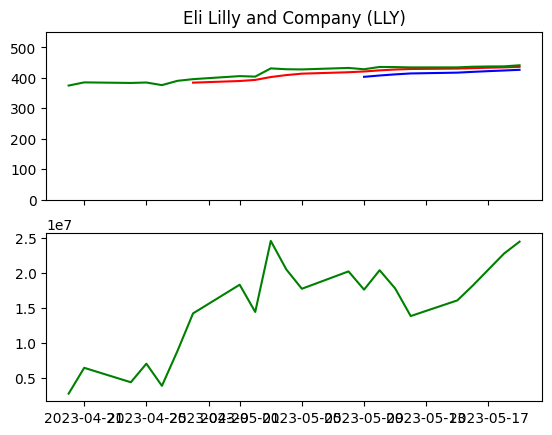

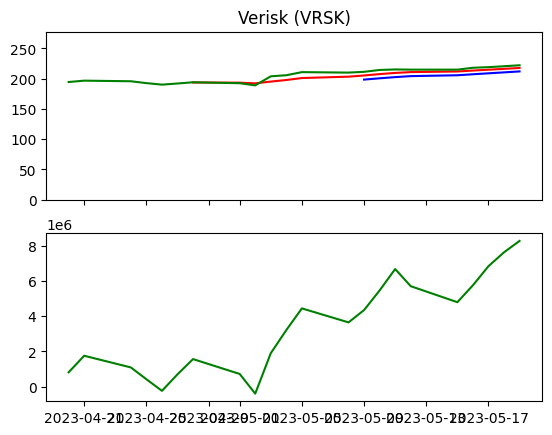

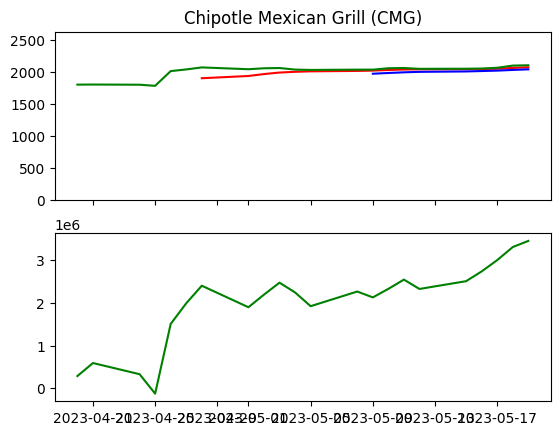

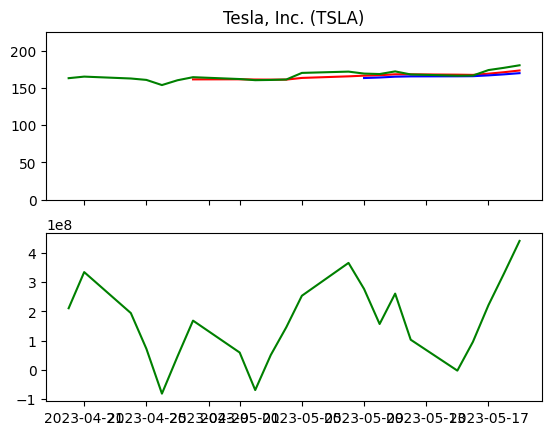

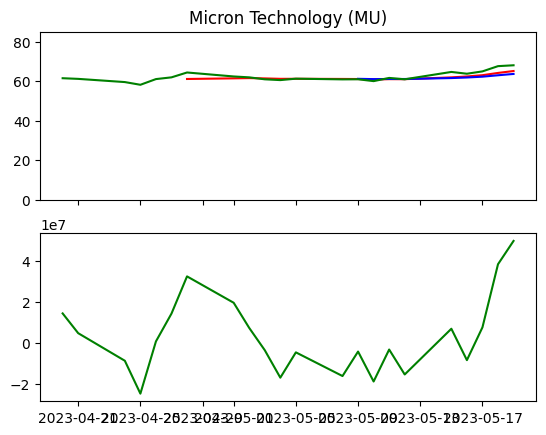

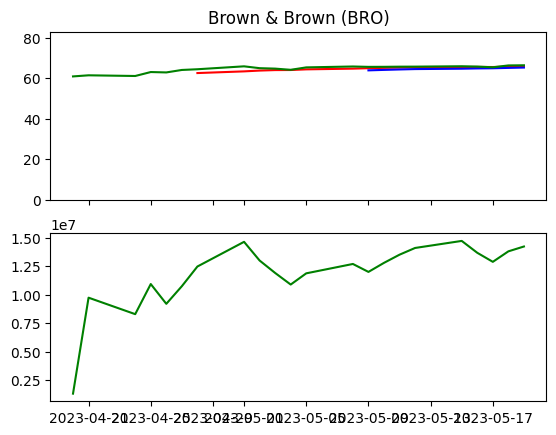

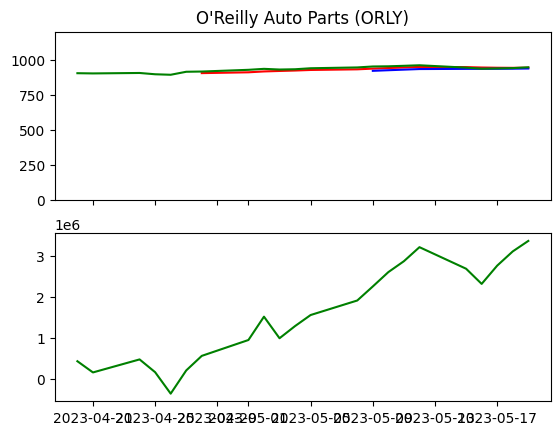

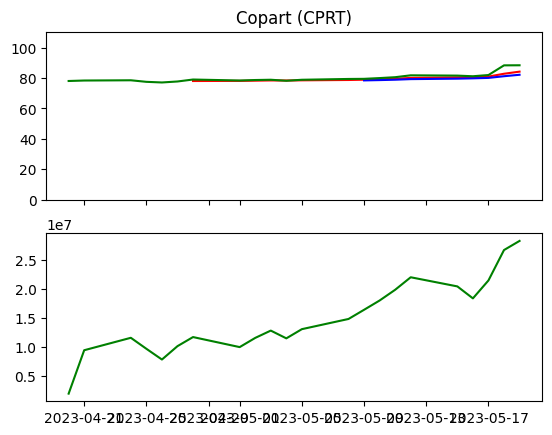

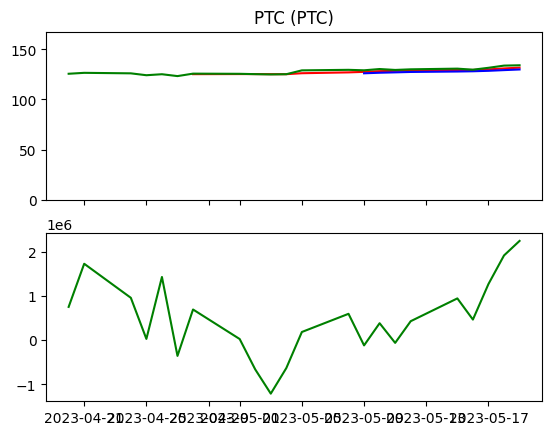

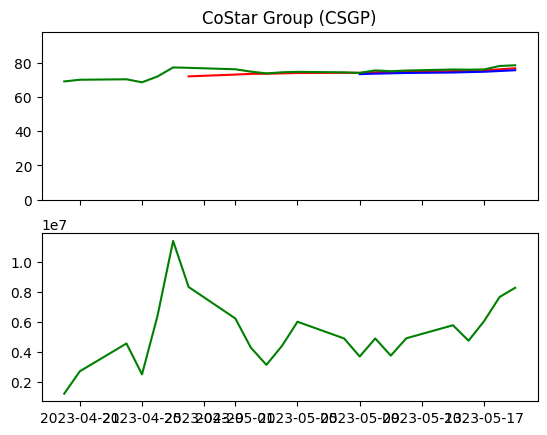

In [23]:
(closes, spreads, volumes, EMA_df, keyStats, tickers_df) = find_stocks(numberOfStocks=500, filterSet=dict({
    #"aboveAvgRatio":0.02, 
    "aboveMinAbs":0.0001, #Originally 0.0001 
    #"minPositivePeriod":4, 
    #"ratioContr":1,
    "latestGrowth":0.0001 #Originally 0.005
     }))

In [ ]:
def myfunc():
    global x
    x=2


myfunc()

In [97]:
difference = (OBV_df[-5:].mean()-OBV_df.mean())
ratio = difference /(OBV_df.mean().abs())
finalList = ratio.sort_values(ascending=False)
finalList

BKNG      9.532745
EXPE      8.864778
NWSA      7.672100
CARR      6.885158
PSX       6.084306
           ...    
ODFL    -80.540480
DG     -204.043337
NKE    -279.587924
OGN    -289.644388
SWK    -618.653260
Length: 500, dtype: float64

In [95]:
OBV_df[testcompany][-5:]


Date
2023-05-15   -1806400.0
2023-05-16   -3559300.0
2023-05-17   -2028500.0
2023-05-18    -513000.0
2023-05-19   -1286384.0
Freq: B, Name: DG, dtype: float64

In [100]:
testcompany = 'EXPE'
print(f"Últimos 5 días: {OBV_df[testcompany][-5:].mean()}, Rango total: {OBV_df[testcompany].mean()}")

Últimos 5 días: 3796099.2, Rango total: 384813.45454545453


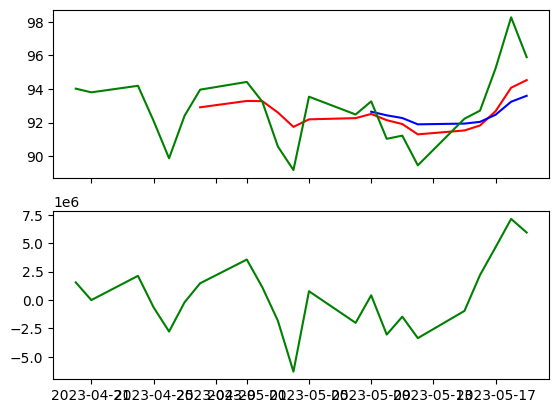

In [101]:
plot_one_with_obv(testcompany, EMA_df, closes, OBV_df)

In [28]:
OBV_df.mean()

A       2.124761e+06
AAL     5.855896e+07
AAP    -3.577751e+06
AAPL   -6.093992e+07
ABBV   -2.263133e+06
            ...     
XYL     5.132298e+06
YUM     6.468130e+06
ZBH     5.811268e+06
ZBRA    1.901030e+05
ZION   -2.742106e+07
Length: 500, dtype: float64

In [ ]:
OBV_df= calc.get_OBV_df(volumes, closes)